# AI-Powered Affiliation Insights: LLM-Based Bibliometric Study of European Medical Informatics Conferences

In [1]:
import pandas as pd
from src.config import OUTPUT_DIR,DATA_DIR
from src.dataset import load_dataset_mie
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from cycler import cycler
import seaborn as sns
from itertools import combinations
import numpy as np
import pycountry
from src.calculator import CoOccurrenceCalculator

## Load Dataset
This section is crucial for initiating your bibliometric analysis of MIE conference papers. Here's what's happening:

The `load_dataset_mie()` function is called to retrieve the dataset containing the **MIE** conference paper information. You can get the initial dataset from [here](https://doi.org/10.6084/m9.figshare.27174759) (see its [article](https://arxiv.org/abs/2410.04602) for more information) This function loads the dataset.

Various steps are performed on the primary dataset to prepare the dataset for analysis in this section. These steps are not performed here and the analysis phase is explained in this section. The two main stages include:
- Affiliation parsing with LLM
    For this purpose, [langflow](https://www.langflow.org/) is used and prompt is designed for it. You can see this prompt [here](/docs/prompt1.md).
- Data cleaning
    This step has been done using another [prompt](/docs/prompt2.md) and its output has been saved in a [csv](/data/university-clean-list.csv) file, and then the data related to universities has been cleaned using it. This process can be used for other data elements as well.

Once the data is loaded, it's converted into a pandas DataFrame using `pd.DataFrame(data)`. This transformation is essential because pandas provides powerful tools for data manipulation and analysis, which will be useful in subsequent steps of your bibliometric study.

By storing the data in a DataFrame named `df`, you're setting up a structured format that allows for easy access, filtering, and analysis of the conference paper information. This DataFrame will serve as the foundation for all further bibliometric analyses in your Jupyter notebook.

In [2]:
data = load_dataset_mie()
df = pd.DataFrame(data)

Remember to inspect your DataFrame after loading to ensure all expected data is present and correctly formatted. You might want to use commands like `df.head()` or `df.info()` to get an initial overview of your dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4606 entries, 0 to 4605
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   title                    4606 non-null   object
 1   year                     4606 non-null   object
 2   journal_issn             4606 non-null   object
 3   language                 4606 non-null   object
 4   doi                      1646 non-null   object
 5   pmid                     4606 non-null   object
 6   citation_count           4606 non-null   int64 
 7   IOSPressVolume           4606 non-null   object
 8   publication_type         4606 non-null   object
 9   authors                  4606 non-null   object
 10  keywords                 4606 non-null   object
 11  topics                   4606 non-null   object
 12  affiliation_countries    4606 non-null   object
 13  affiliations             4606 non-null   object
 14  structural_affiliations  4606 non-null  

## Preparation Steps

### Defining Essential Variables
In this section, we set up crucial variables that will be used throughout our bibliometric analysis of MIE conference papers. Let's break down what each variable represents:

1. `shape_file`: This variable stores the path to a shapefile, which is likely used for geographical visualizations. The file is located in a directory structure starting with `DATA_DIR`, followed by "ne_110m_admin_0_countries". This shapefile probably contains country boundaries at a 1:110 million scale. You can download other maps according to your preferences. We used the shapefile taken from the [naturalearthdata site](https://www.naturalearthdata.com/).

2. `save_mode`: This boolean variable is set to `False`. It's likely used to control whether certain outputs (such as plots or csv export data) should be saved to disk during the analysis. When set to `True`, it would enable saving; when `False`, it might skip saving steps to speed up the analysis process.

In [5]:
shape_file = DATA_DIR / "ne_110m_admin_0_countries" / "ne_110m_admin_0_countries.shp"
save_mode = True

### Define some function
In this section, we define a crucial function `create_table()` that will be used throughout our bibliometric analysis to present data in a visually appealing and easy-to-read format. 

In [94]:
# Function to create a table with auto-sized columns and zebra stripes
def create_table(ax, data, title):
    # Create the table
    table = ax.table(cellText=data.values,
                     colLabels=data.columns,
                     cellLoc='center',
                     loc='center')
    ax.set_title(title, fontsize=16)  # Increased subtitle font size
    ax.axis('off')
    
    # Auto-size columns and set larger font size
    table.auto_set_font_size(False)
    # table.set_fontsize(12)  # Increased font size
    table.set_fontsize(20)  # Increased font size
    table.scale(1, 1.8)  # Adjusted scale for larger cells
    
    # Adjust column widths and add zebra stripes
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#4472C4')  # Header color
        else:
            cell.set_facecolor('#D9E1F2' if row % 2 == 0 else 'white')  # Alternating row colors
        cell.set_height(0.1)
        cell._text.set_wrap(True)
    
    # Get the maximum width for each column
    col_widths = [max([len(str(data.iloc[i, j])) for i in range(len(data))] + [len(str(data.columns[j]))]) 
                  for j in range(len(data.columns))]
    
    # Set column widths
    for j, width in enumerate(col_widths):
        table.auto_set_column_width(j)
    
    return table

## Article Trends
This section focuses on analyzing and visualizing the trends in the number of articles published over the years at MIE conferences. Here's what the code accomplishes:

1. Data Aggregation: The code groups the data by year and counts the number of articles (titles) for each year, creating a new DataFrame `df_year`.

2. Data Type Conversion: The 'year' column is converted to a numeric type to ensure proper plotting and analysis.

3. Trend Prediction: Using numpy's `polyfit` function, a linear regression model is fitted to the data to predict future trends. This creates a prediction line that extends the observed pattern.

4. Visualization:
   - A line chart is created using matplotlib, showing both the actual number of articles per year and the predicted trend.
   - The actual data points are plotted in blue with circular markers.
   - The prediction line is plotted in red.
   - The chart includes labels for the x-axis (Year) and y-axis (Number of Articles), as well as a title and legend.

5. Output: The plot is saved as an image file and displayed in the notebook.

This visualization allows you to observe how the number of articles has changed over time and provides a simple linear prediction of future trends. It's a valuable tool for understanding the growth or fluctuations in conference contributions over the years.

Keep in mind that while the linear prediction offers a general trend, actual future numbers may vary due to various factors affecting conference participation and paper submissions.

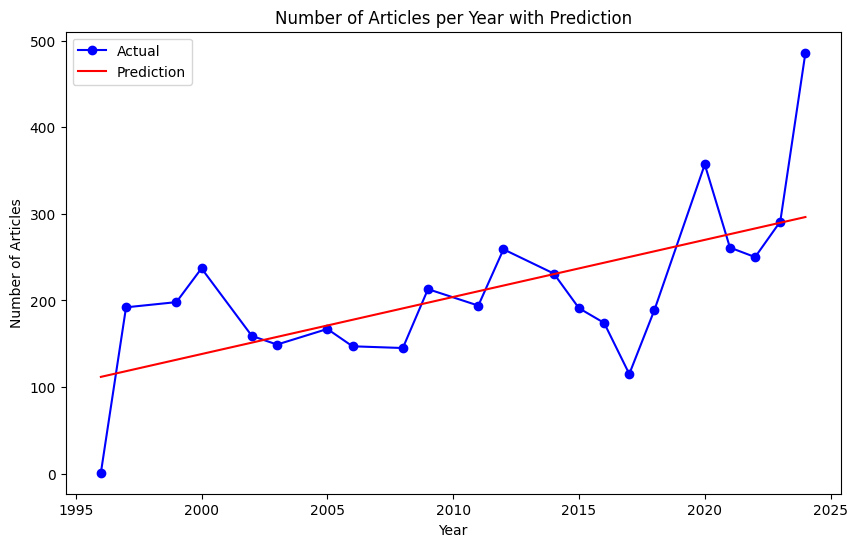

In [95]:
df_year = df.groupby('year')['title'].count().reset_index()

# Convert 'year' column to numeric type
df_year['year'] = pd.to_numeric(df_year['year'])

# Calculate the prediction line
x = df_year['year'].values
y = df_year['title'].values
a, b = np.polyfit(x, y, 1)  # Fit a linear regression model
predicted_y = a * x + b  # Calculate the predicted values

# Create the line chart
plt.figure(figsize=(10, 6))
plt.plot(df_year['year'], df_year['title'], 'bo-', label='Actual')
plt.plot(df_year['year'], predicted_y, 'r-', label='Prediction')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.title('Number of Articles per Year with Prediction')
plt.legend()

# Show the plot
if save_mode:
    plt.savefig(OUTPUT_DIR  / "Number of Articles per Year with Prediction.png")
plt.show()

## Citation

### Articles with No Citations vs At Least One Citation by Year

This section analyzes and visualizes the distribution of articles based on their citation counts over the years. Here's a breakdown of what the code accomplishes:

1. Data Preparation:
   - Two boolean columns are created: 'no_citations' for articles with zero citations and 'has_citations' for articles with at least one citation.
   - A complete range of years is generated to ensure all years are represented in the final visualization, even if some years have no data.

2. Data Aggregation:
   - The data is grouped by year, counting the number of articles with and without citations for each year.
   - This grouped data is then merged with the complete range of years, filling in any missing years with zero counts.

3. Visualization:
   - A stacked bar chart is created using matplotlib, showing the distribution of articles with and without citations for each year.
   - Red bars represent articles with no citations, while green bars represent articles with at least one citation.
   - The x-axis shows the years, and the y-axis represents the number of articles.
   - Labels, title, and legend are added for clarity.

4. Formatting:
   - X-axis labels (years) are rotated 45 degrees for better readability.
   - The layout is adjusted to prevent cutting off labels.

5. Output:
   - The plot is saved as an image file and displayed in the notebook.

This visualization provides valuable insights into the citation patterns of MIE conference papers over time. It allows you to observe:

- The overall trend in the number of published articles.
- The proportion of articles that receive citations versus those that don't.
- Any changes in citation patterns over the years.


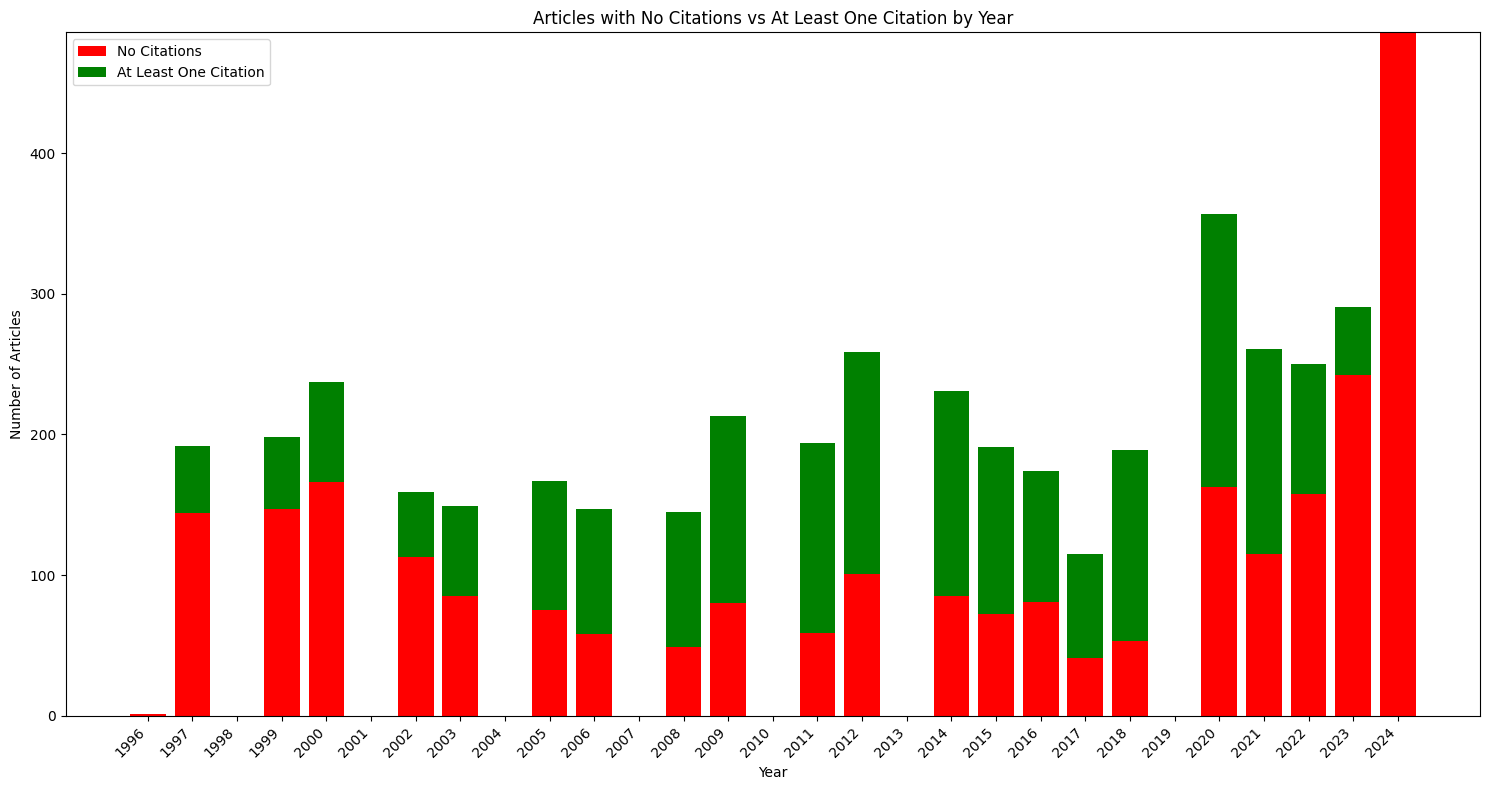

In [96]:
# Create boolean columns for articles with and without citations
df['no_citations'] = df['citation_count'] == 0
df['has_citations'] = df['citation_count'] > 0

# Get the range of years
min_year = df['year'].min()
max_year = df['year'].max()
all_years = range(int(min_year), int(max_year) + 1)

# Create a DataFrame with all years
all_years_df = pd.DataFrame({'year': all_years})

# Group by year and count articles with and without citations
grouped = df.groupby('year').agg({
    'no_citations': 'sum',
    'has_citations': 'sum'
}).reset_index()

# Convert 'year' to int in both DataFrames
all_years_df['year'] = all_years_df['year'].astype(int)
grouped['year'] = grouped['year'].astype(int)

# Merge with all years
grouped = pd.merge(all_years_df, grouped, on='year', how='left').fillna(0)

# The rest of your code remains the same
plt.figure(figsize=(15, 8))
plt.bar(grouped['year'], grouped['no_citations'], label='No Citations',color='red')
plt.bar(grouped['year'], grouped['has_citations'], bottom=grouped['no_citations'], label='At Least One Citation',color='green')

plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.title('Articles with No Citations vs At Least One Citation by Year')
plt.legend()

# Rotate x-axis labels
plt.xticks(grouped['year'], rotation=45, ha='right')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show & save the plot
if save_mode:
    plt.savefig(OUTPUT_DIR  / "Articles with No Citations vs At Least One Citation by Year.png")
plt.show()


### Trends in Citation Patterns and Future Predictions

This section focuses on analyzing the historical citation patterns of MIE conference papers and predicting future trends based on these patterns.

The code begins by aggregating citation data by year. By grouping the papers according to their publication year and summing their citation counts, we can observe how citation patterns have changed over time.

Next, we calculate a linear trend using a simple linear regression (`np.polyfit`). This allows us to model the relationship between the year of publication and the total citation count, which is then used to predict future citation behavior.

The final output is a line chart:
- The blue line represents the actual total citations for each year.
- The red line represents the predicted trend based on the linear regression model.

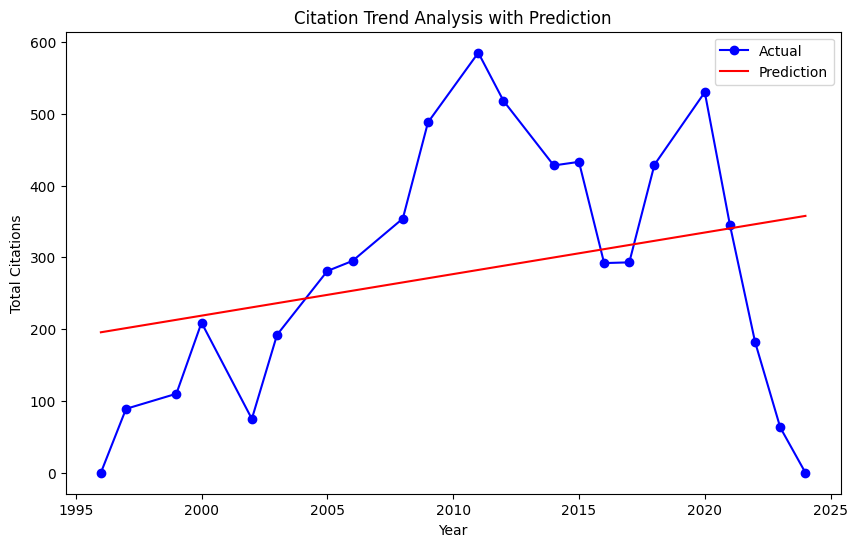

In [97]:
# Group by year and sum the citation counts
df_citations = df.groupby('year')['citation_count'].sum().reset_index()

# Convert 'year' column to numeric type
df_citations['year'] = pd.to_numeric(df_citations['year'])

# Calculate the prediction line
x = df_citations['year'].values
y = df_citations['citation_count'].values
a, b = np.polyfit(x, y, 1)  # Fit a linear regression model
predicted_y = a * x + b  # Calculate the predicted values

# Create the line chart
plt.figure(figsize=(10, 6))
plt.plot(df_citations['year'], df_citations['citation_count'], 'bo-', label='Actual')
plt.plot(df_citations['year'], predicted_y, 'r-', label='Prediction')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Total Citations')
plt.title('Citation Trend Analysis with Prediction')
plt.legend()

# Show the plot
if save_mode:
    plt.savefig(OUTPUT_DIR / "Citation Trend Analysis with Prediction.png")
plt.show()


## Authors

### Export Table of Authors, Citation Count, Article Number

This section focuses on generating a comprehensive table of authors, their total citation counts, and the number of articles they have contributed to the MIE conference proceedings. The goal is to provide a clear summary of each author's academic impact based on their publications.

The code starts by expanding the list of authors, ensuring that each author has their own row in the dataset. It then groups the data by each author to:
- Sum up the total citations for each author (`citation_count`).
- Count the number of articles authored by each individual (`article_count`).

The result is a table that ranks authors by their total citation count, with the most highly cited authors appearing at the top. This table is exported as a CSV file for further analysis, making it easy to explore or share this data.

The file is saved as `table_authors_citation_article_count.csv`.

In [98]:
# Expand authors so each author gets their own row
authors_expanded = df.explode('authors')

# Group by authors and calculate the sum of citation_count and count of documents
author_stats = authors_expanded.groupby('authors').agg(
    citation_count=('citation_count', 'sum'),
    article_count=('authors', 'count')
).reset_index()

# Sort the DataFrame by citation_count in descending order
result_sorted = author_stats.sort_values(by='citation_count', ascending=False)

if save_mode:
    result_sorted.to_csv(OUTPUT_DIR / "table_authors_citation_article_count.csv")
print("Tables created and saved successfully in `table_authors_citation_article_count.csv`.")

Tables created and saved successfully in `table_authors_citation_article_count.csv`.


### Top Authors by Articles and Citations

In this section, we identify the most influential authors in MIE conference papers, ranking them both by the number of articles they've contributed and by the total number of citations their work has received. This allows us to highlight prolific authors and those whose work has had the greatest academic impact.

The code performs the following key steps:
- **Top n authors by citations**: Selects the top 5 authors based on the total number of citations.
- **Top n authors by articles**: Selects the top 5 authors based on the number of articles they have authored.
  
It then creates two separate tables:
- One ranked by article count, showing the authors with the most publications.
- Another ranked by citation count, showing the authors whose work has been most cited.

Each table includes a "Rank" column for easy comparison. The two tables are displayed side by side in a figure, giving a clear comparison between authors' productivity and impact. The final image, titled "Top Authors: By Articles and Citations," is saved as `authors_comparison_tables.png`.

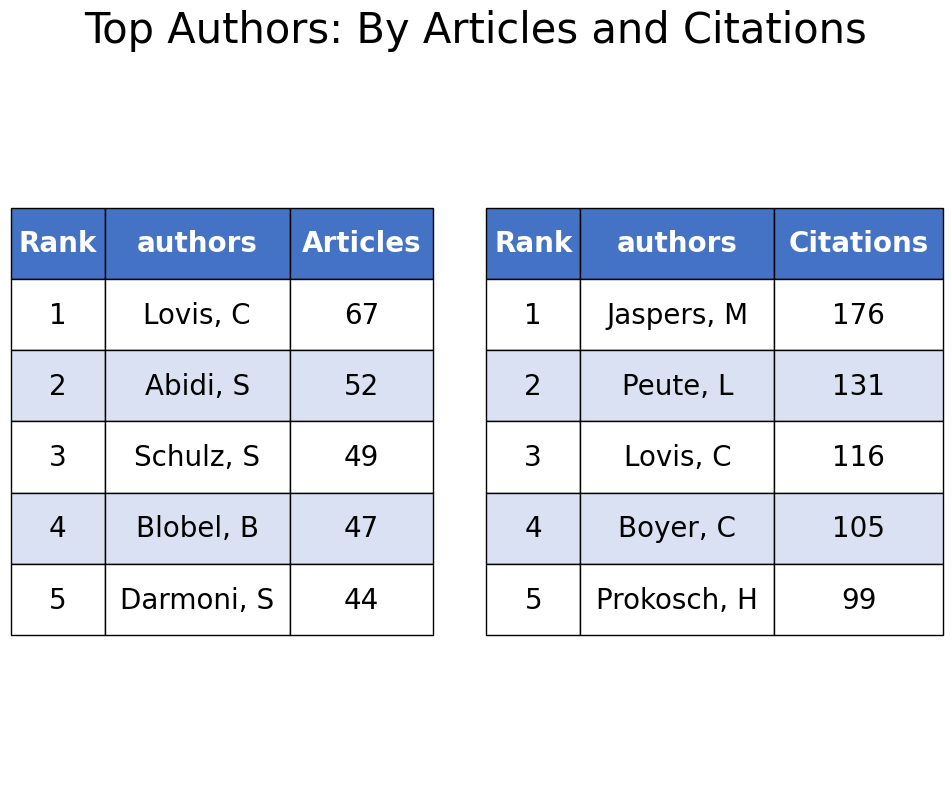

Tables drawn and saved successfully in `authors_comparison_tables.png`.


In [99]:
# Get the top author (let's say top 10 for this example)
top = 5
top_n_by_citation_count = result_sorted.sort_values(by='citation_count', ascending=False).reset_index(drop=True).head(top)
top_n_by_article_count =  result_sorted.sort_values(by='article_count', ascending=False).reset_index(drop=True).head(top)

# Create two sorted dataframes
df_by_article = top_n_by_article_count[['authors', 'article_count']].sort_values('article_count', ascending=False)
df_by_article = df_by_article.rename(columns={'article_count': 'Articles'})
df_by_article['Rank'] = range(1, len(df_by_article) + 1)
df_by_article = df_by_article[['Rank'] + [col for col in df_by_article.columns if col != 'Rank']]

df_by_citation = top_n_by_citation_count[['authors', 'citation_count']].sort_values('citation_count', ascending=False)
df_by_citation = df_by_citation.rename(columns={'citation_count': 'Citations'})
df_by_citation['Rank'] = range(1, len(df_by_citation) + 1)
df_by_citation = df_by_citation[['Rank'] + [col for col in df_by_citation.columns if col != 'Rank']]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))  # Increased figure size
fig.suptitle("Top Authors: By Articles and Citations", fontsize=30)  # Increased title font size


table1 = create_table(ax1, df_by_article,"")
table2 = create_table(ax2, df_by_citation,"")
# Adjust layout and save the plot
plt.tight_layout()
if save_mode:
    plt.savefig(OUTPUT_DIR / "authors_comparison_tables.png", dpi=300, bbox_inches='tight')
plt.show()

print("Tables drawn and saved successfully in `authors_comparison_tables.png`.")

## Country

### Evaluating Missing Country Information in Affiliations

This section assesses the completeness of country data in the affiliations of authors from MIE conference papers. Understanding the geographical distribution of authors is critical in bibliometric analysis, but missing or incomplete affiliation data can hinder this analysis. Therefore, this evaluation helps identify gaps in the dataset.

The code performs the following steps:

1. **Check for missing country data**: A function (`has_empty_country`) is defined to check if any of the affiliations in the dataset are missing country information (i.e., if the country field is `None` or an empty string). This is applied to the `structural_affiliations` column.
  
2. **Count articles with missing country information**: The code counts the number of articles that have at least one author whose country affiliation is missing. This provides insight into how many papers have incomplete geographical data.

3. **List affected articles**: The code also prints the PMIDs (PubMed Identifiers) of articles with missing country data, making it easier to locate and address these gaps.

4. **Count missing country entries across all affiliations**: Lastly, a more granular evaluation is performed by counting how many affiliations (across all authors) have empty or null country values. This gives a detailed count of missing country information at the individual affiliation level.

By running this evaluation, users can better understand the extent of missing country data in the dataset and determine whether further cleaning or manual curation is necessary.

In [100]:
# Define a function to check if any country is empty or null
def has_empty_country(affiliations):
    return any(aff.get('country') in [None, ''] for aff in affiliations)

# Apply the function to the 'structural_affiliations' column
df['has_empty_country'] = df['structural_affiliations'].apply(has_empty_country)

# Count the number of articles with at least one empty or null country
count_empty_country = df['has_empty_country'].sum()

print(f"Number of articles with at least one empty or null country: {count_empty_country}")

Number of articles with at least one empty or null country: 127


In [101]:
# Filter the DataFrame to get only the rows with empty or null countries
df_empty_country = df[df['has_empty_country']]

# # Print the PMIDs of articles with at least one empty or null country
# print("PMIDs of articles with at least one empty or null country:")
# for pmid in df_empty_country['pmid']:
#     print(pmid)

# If you want to print the count as well
print(f"\nTotal number of articles with at least one empty or null country: {len(df_empty_country)}")


Total number of articles with at least one empty or null country: 127


In [102]:
# Function to count empty or null countries in structural_affiliations
def count_empty_countries(affiliations):
    return sum(1 for aff in affiliations if not aff.get('country'))

# Apply the function to the structural_affiliations column
empty_country_counts = df['structural_affiliations'].apply(count_empty_countries)

# Sum up the total count
total_empty_countries = empty_country_counts.sum()

print(f"Number of structural_affiliations with empty or null country: {total_empty_countries}")


Number of structural_affiliations with empty or null country: 168


### Country-wise Citation and Article Count

This section generates a table summarizing the contributions of different countries to the MIE conference papers, specifically focusing on the total number of citations and articles associated with each country.

**Key steps in the code:**

1. **Explode the affiliations data**: The `structural_affiliations` column, which contains affiliation details as a list, is exploded so that each affiliation appears in its own row.

2. **Normalize affiliation details**: The exploded data is normalized to extract country-specific information from the affiliations.

3. **Combine data**: The exploded data (with detailed affiliations) is concatenated back with the main dataset to retain relevant information such as article titles and citation counts.

4. **Group by country**: The dataset is then grouped by country, calculating:
   - The total number of citations (`citation_count`) for papers associated with authors from that country.
   - The total number of articles (`article_count`) contributed by authors from each country.

5. **Sorting and saving**: The resulting table is sorted by citation count in descending order, allowing us to identify which countries have the highest academic impact based on citations. This table is saved as `table_countries_citation_article_count.csv`.

In [103]:
# Explode the structural_affiliations column
df_exploded = df.explode('structural_affiliations')

# Normalize the structural_affiliations column
df_normalized = pd.json_normalize(df_exploded['structural_affiliations'])

# Reset the index of df_exploded and drop the structural_affiliations column
df_exploded = df_exploded.reset_index(drop=True).drop('structural_affiliations', axis=1)

# Concatenate the DataFrames
df_final = pd.concat([df_exploded, df_normalized], axis=1)

# Group by country and aggregate
result = df_final.groupby('country').agg({
    'citation_count': 'sum',
    'title': 'count'
}).rename(columns={'title': 'article_count'}).reset_index()

# Sort the result by citation_count in descending order
df_country = result.sort_values(by='citation_count', ascending=False).reset_index(drop=True)

if save_mode:
    df_country.to_csv(OUTPUT_DIR / "table_countries_citation_article_count.csv")
print("Tables created and saved successfully in `table_countries_citation_article_count.csv`.")


Tables created and saved successfully in `table_countries_citation_article_count.csv`.


### Top Contributing Countries by Articles and Citations

In this section, we highlight the top countries that have contributed to MIE conference papers, ranking them by both the number of articles authored and the total number of citations received. This comparison helps identify which countries are most productive and which have the greatest academic impact in the field.

**Key steps in the code:**

1. **Top 10 countries by citations**: The code selects the top 10 countries based on total citation counts, identifying the countries whose research has garnered the most attention.
  
2. **Top 10 countries by articles**: Similarly, the code identifies the top 10 countries by the number of articles, highlighting which countries have the highest volume of research contributions.

3. **Create two data tables**:
   - One table ranks countries by the number of articles (`Articles`), showing which nations are the most prolific.
   - The other table ranks countries by citations (`Citations`), reflecting their academic impact.

4. **Visual representation**: Two side-by-side tables are displayed in a single figure, allowing for an easy comparison between the top countries in terms of research output (articles) and research impact (citations). The figure is saved as `country_comparison_tables.png`.

This visualization provides a clear overview of the most influential countries in the MIE conference papers, offering insights into both productivity and impact across geographic regions.

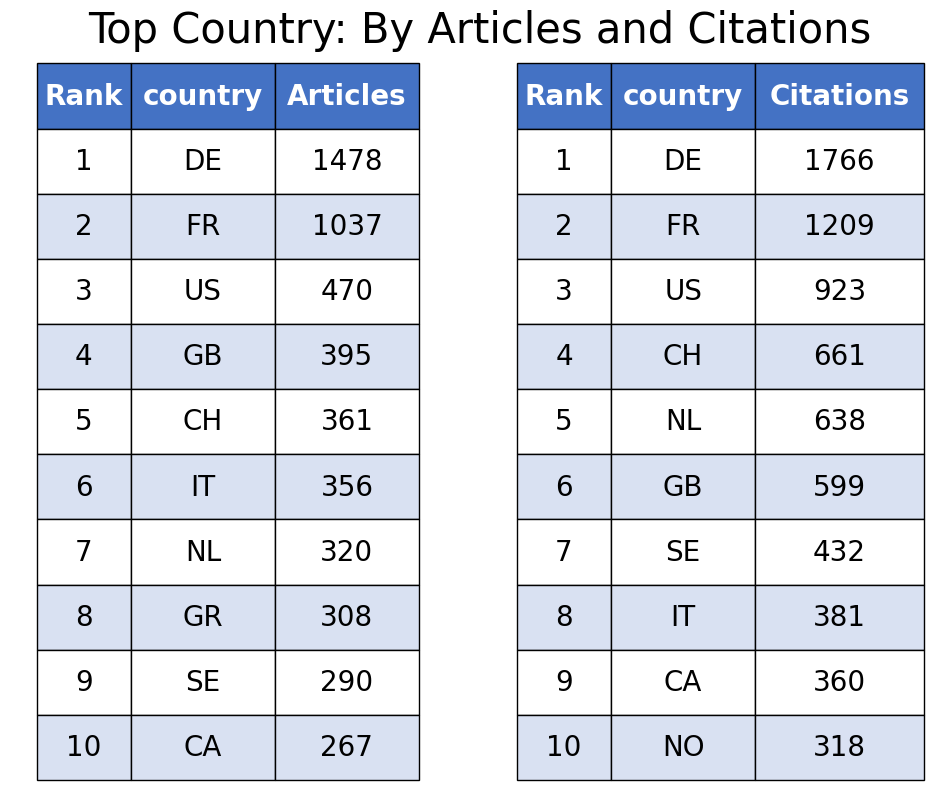

Tables drawn and saved successfully in `country_comparison_tables.png`.


In [104]:
# Get the top country (let's say top 10 for this example)
top = 10
top_n_by_citation_count = result.sort_values(by='citation_count', ascending=False).reset_index(drop=True).head(top)
top_n_by_article_count =  result.sort_values(by='article_count', ascending=False).reset_index(drop=True).head(top)

# Create two sorted dataframes
df_by_article = top_n_by_article_count[['country', 'article_count']].sort_values('article_count', ascending=False)
df_by_article = df_by_article.rename(columns={'article_count': 'Articles'})
df_by_article['Rank'] = range(1, len(df_by_article) + 1)
df_by_article = df_by_article[['Rank'] + [col for col in df_by_article.columns if col != 'Rank']]

df_by_citation = top_n_by_citation_count[['country', 'citation_count']].sort_values('citation_count', ascending=False)
df_by_citation = df_by_citation.rename(columns={'citation_count': 'Citations'})
df_by_citation['Rank'] = range(1, len(df_by_citation) + 1)
df_by_citation = df_by_citation[['Rank'] + [col for col in df_by_citation.columns if col != 'Rank']]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))  # Increased figure size
fig.suptitle("Top Country: By Articles and Citations", fontsize=30)  # Increased title font size

# Create tables
# table1 = create_table(ax1, top_n_by_article_count, "Sorted by Articles")
# table2 = create_table(ax2, df_by_citation, "Sorted by Citations")

table1 = create_table(ax1, df_by_article,"")
table2 = create_table(ax2, df_by_citation,"")
# Adjust layout and save the plot
plt.tight_layout()
if save_mode:
    plt.savefig(OUTPUT_DIR / "country_comparison_tables.png", dpi=300, bbox_inches='tight')
plt.show()

print("Tables drawn and saved successfully in `country_comparison_tables.png`.")

### Citation per Article Index by Country

In this section, we calculate the **Citation per Article Index** for each country, which measures the average number of citations received per article. This index provides a more nuanced view of academic impact by accounting for both the number of articles produced and the citations received, offering insights into the relative influence of a country's research output.

**Key steps in the code:**

1. **Exploding and normalizing affiliation data**: 
   - The `structural_affiliations` column is exploded, so each author’s affiliation appears on its own row.
   - This exploded data is normalized to extract detailed country-level information.

2. **Grouping by country**:
   - The data is grouped by country, and for each country, two key metrics are calculated:
     - Total citations (`citation_count`).
     - Total number of articles (`article_count`).

3. **Calculating the Citation per Article Index**:
   - The index is calculated as the ratio of total citations to the number of articles for each country (`citation_count / article_count`). This provides a measure of the average impact of articles from each country.

4. **Sorting by impact**: 
   - The countries are sorted in descending order based on their Citation per Article Index, highlighting the countries whose papers are most influential on average.

5. **Saving and displaying results**:
   - The results are saved to a CSV file (`table_countries_index.csv`) for further analysis, and the final index table is printed for immediate review.

This analysis helps identify countries with high-impact research, independent of their total output, offering a deeper understanding of the academic influence of different regions.

In [105]:
# Explode the structural_affiliations column
df_exploded = df.explode('structural_affiliations')

# Normalize the structural_affiliations column
df_normalized = pd.json_normalize(df_exploded['structural_affiliations'])

# Reset the index of df_exploded and drop the structural_affiliations column
df_exploded = df_exploded.reset_index(drop=True).drop('structural_affiliations', axis=1)

# Concatenate the DataFrames
df_final = pd.concat([df_exploded, df_normalized], axis=1)

# Group by country and aggregate
country_index = df_final.groupby('country').agg({
    'citation_count': 'sum',
    'title': 'count'
}).rename(columns={'title': 'article_count'}).reset_index()

country_index['index'] = country_index['citation_count'] / country_index['article_count']
country_index = country_index.sort_values('index', ascending=False)

if save_mode:
    country_index.to_csv(OUTPUT_DIR / "table_countries_index.csv")
print("Tables created and saved successfully in `table_countries_index.csv`.")


Tables created and saved successfully in `table_countries_index.csv`.


This section focuses on analyzing the research impact of different countries based on their citation performance. The Citation per Article Index is a metric that helps evaluate the average influence of publications from each country.

The code generates a bar chart visualizing the top 25 countries ranked by their Citation per Article Index. This index is calculated by dividing the total number of citations received by the total number of articles published for each country, providing insight into the average impact of research output.

Key points of this visualization:

1. It highlights countries whose publications tend to receive more citations on average.
2. The use of different colors for each bar enhances the readability of the chart.
3. Countries are sorted in descending order of their index values.
4. The x-axis labels are rotated for better readability, given the potentially long list of country names.

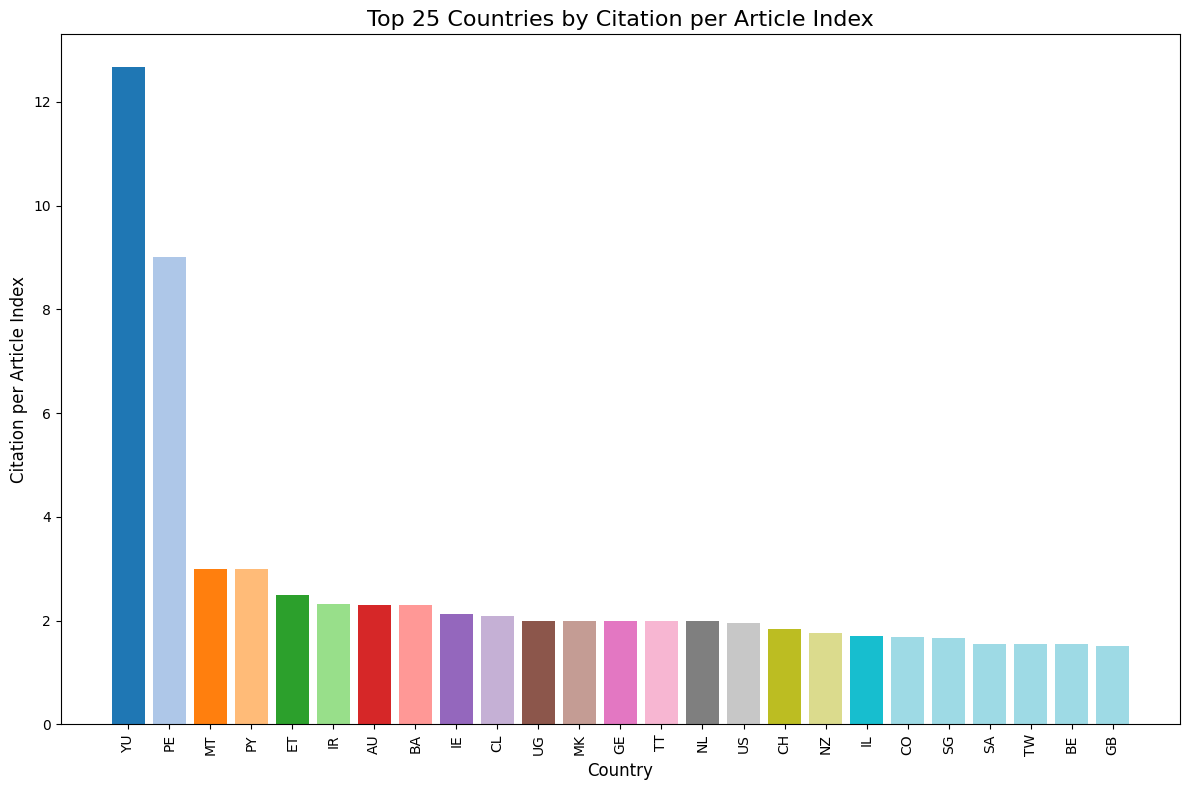

In [106]:
top = 25

# Sort the country index and select the top n
top_countries = country_index.head(top)

# Create a list of colors using the updated method for colormap
colors = plt.get_cmap('tab20', 20)  # Using 'tab20' colormap

# Create the bar chart
plt.figure(figsize=(12, 8))
plt.bar(top_countries['country'], top_countries['index'], color=colors(np.arange(len(top_countries))))


# Add labels and title
plt.xlabel('Country', fontsize=12)
plt.ylabel('Citation per Article Index', fontsize=12)
plt.title(f'Top {top} Countries by Citation per Article Index', fontsize=16)

# Rotate x labels for better readability
plt.xticks(rotation=90, fontsize=10)

# Tight layout for better spacing
plt.tight_layout()

# Save the plot
if save_mode:
    plt.savefig(OUTPUT_DIR / f"top_{top}_countries_citation_per_article_index.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


### Heatmap of Top 10 Country Co-occurrence
In this section, we visualize the collaboration patterns between countries based on co-authorships in MIE conference papers. This heatmap highlights the top 10 most frequent country collaborations, helping to reveal international partnerships and the most active contributors.

1. **Extracting Countries**: The `get_countries` function is used to extract the countries associated with each author’s institutional affiliation. We apply this function to the data, ensuring that only valid country data is extracted from the nested structures.

2. **Filtering Data**: Any records without valid country data are removed, ensuring the analysis is based on papers that have country-level affiliation information.

3. **Building the Co-occurrence Matrix**: For each paper, we look at the countries represented by the co-authors and calculate how often any two countries co-occurred as part of the same paper. A co-occurrence matrix is generated where each entry indicates how many times two countries appeared together in the dataset.

4. **Top 10 Country Pairs**: From the co-occurrence matrix, we identify the top 10 most frequent country pairs. These represent the strongest international collaborations in the dataset.

5. **Heatmap Visualization**: A heatmap is created to visualize the top 10 country pairs. The intensity of the color represents the frequency of collaborations between the two countries. This graphical representation provides an intuitive understanding of international partnerships.

6. **Displaying Results**: Finally, the heatmap is displayed and saved as an image file, and the top 10 country pairs with their co-occurrence counts are printed for further analysis.

This step provides a clear view of which countries collaborate most frequently in the MIE conference papers, offering insights into global research networks.

Heatmap saved as 'top_10_country_co_occurrence_heatmap.png'


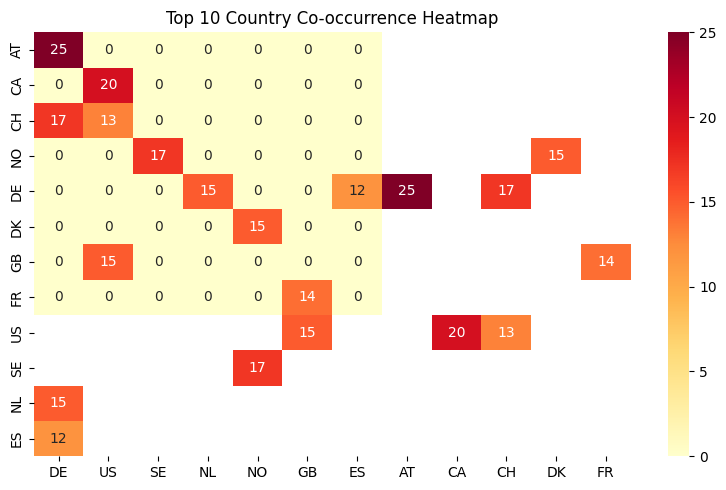


Top 10 Country Pairs by Co-occurrence:
AT - DE: 25.0
CA - US: 20.0
CH - DE: 17.0
NO - SE: 17.0
DE - NL: 15.0
DK - NO: 15.0
GB - US: 15.0
FR - GB: 14.0
CH - US: 13.0
DE - ES: 12.0


In [107]:
# Function to safely extract countries
def get_countries(affiliations):
    if isinstance(affiliations, list):
        return [aff['country'] for aff in affiliations if isinstance(aff, dict) and 'country' in aff and aff['country']]
    return []

# Apply the function to get countries
df['countries'] = df['structural_affiliations'].apply(get_countries)

# Filter out empty country lists
df = df[df['countries'].apply(len) > 0]

# Create co-occurrence matrix
all_countries = sorted(set(country for countries in df['countries'] for country in countries if country))
co_occurrence = pd.DataFrame(0, index=all_countries, columns=all_countries)

for countries in df['countries']:
    for c1, c2 in combinations(set(countries), 2):
        co_occurrence.loc[c1, c2] += 1
        co_occurrence.loc[c2, c1] += 1

# Get top 10 country pairs
top_pairs = co_occurrence.where(np.triu(np.ones(co_occurrence.shape), k=1).astype(bool))
top_pairs = top_pairs.stack().nlargest(10)

# Create a new DataFrame for the top 10 pairs
top_10_df = pd.DataFrame(index=range(10), columns=['Country1', 'Country2', 'Co-occurrences'])
for i, (pair, value) in enumerate(top_pairs.items()):
    top_10_df.loc[i] = [pair[0], pair[1], value]

# Create a new matrix for the heatmap
heatmap_data = pd.DataFrame(0, index=top_10_df['Country1'].unique(), columns=top_10_df['Country2'].unique())
for _, row in top_10_df.iterrows():
    heatmap_data.loc[row['Country1'], row['Country2']] = row['Co-occurrences']
    heatmap_data.loc[row['Country2'], row['Country1']] = row['Co-occurrences']

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='g', cbar=True)
plt.title('Top 10 Country Co-occurrence Heatmap')
plt.tight_layout()

# Save the plot
if save_mode:
    plt.savefig(OUTPUT_DIR / 'top_10_country_co_occurrence_heatmap.png', dpi=300, bbox_inches='tight')
print("Heatmap saved as 'top_10_country_co_occurrence_heatmap.png'")

# Show the plot
plt.show()

# Print top 10 country pairs
print("\nTop 10 Country Pairs by Co-occurrence:")
for _, row in top_10_df.iterrows():
    print(f"{row['Country1']} - {row['Country2']}: {row['Co-occurrences']}")


![](/output/vos_viewer_countries_co_occurrence.png)

### Number of Articles geomap
This section provides a geographical visualization of the number of articles published by authors from different countries in the MIE conference. A geomap is created to illustrate the global distribution of research contributions, allowing us to see which countries are the most active in the MIE conference.

1. **Country Code Mapping**: The country codes in the dataset may be in alpha-2 format (e.g., "US" for the United States). However, for geographical mapping, we need alpha-3 country codes (e.g., "USA") and country names. We create a dictionary using the `pycountry` library to map alpha-2 codes to alpha-3 codes and full country names.

2. **Error Handling for Missing Codes**: In cases where a country code is missing or invalid, we handle the error by assigning default values ("Unknown") to ensure the data remains usable.

3. **Reading the World Map**: We load a shapefile that contains the geographic boundaries of countries. This file is essential for plotting the geomap, as it defines the shapes and locations of all countries.

4. **Merging Data with the World Map**: The country-level article counts are merged with the world map data using alpha-3 country codes. This ensures that each country on the map is linked with its corresponding article count.

5. **Plotting the Geomap**: The world map is visualized using color shading to represent the number of articles. Countries with higher article counts are displayed in darker shades, while countries with no contributions are displayed in light grey. A color legend is added to clarify the meaning of the shading.

6. **Annotations**: To provide additional clarity, countries with article contributions are annotated with their alpha-3 country code and the exact number of articles, allowing viewers to quickly identify contributions from specific regions.

7. **Finalizing the Map**: The map is saved as an image and displayed. This provides a clear and interactive way to understand the geographical distribution of research output in the MIE conference.

This step highlights global research contributions by visually mapping where MIE papers originate, offering insights into the regional impact and participation in the conference.

Map saved as 'articles_by_country_map.png'


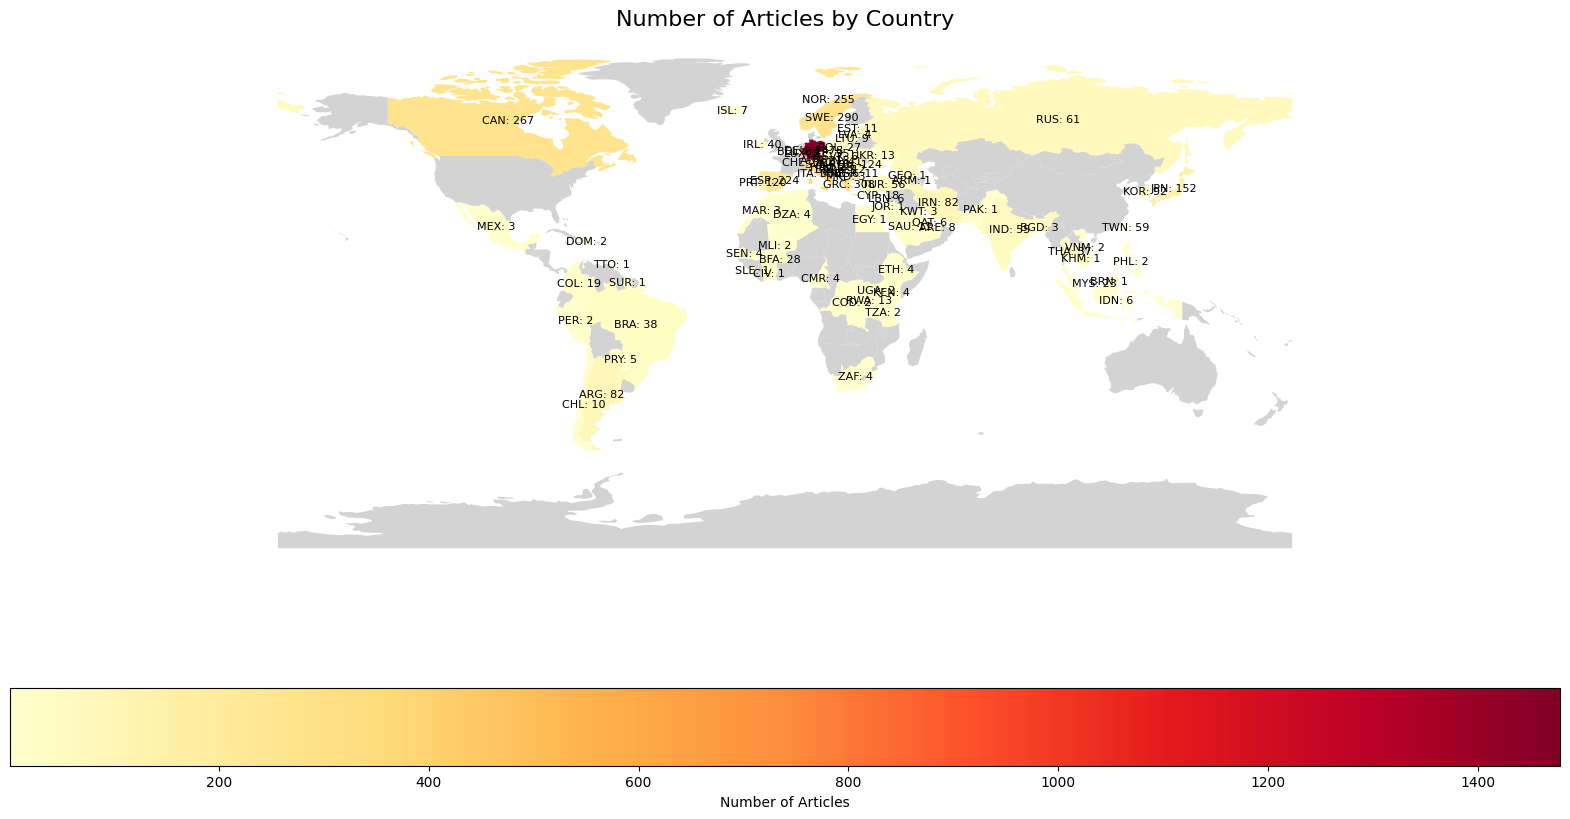

In [108]:
# Create a dictionary to map alpha-2 codes to alpha-3 codes and country names
country_dict = {country.alpha_2: (country.alpha_3, country.name) for country in pycountry.countries}

# Add the new columns with error handling
def get_country_info(code):
    info = country_dict.get(code)
    if info is None:
        return 'Unknown', 'Unknown'  # Replace 'Unknown' with your desired default values
    else:
        return info[0], info[1]

df_country['alpha_3'] = df_country['country'].map(lambda x: get_country_info(x)[0])
df_country['country_name'] = df_country['country'].map(lambda x: get_country_info(x)[1])

# Get Shape file
world = gpd.read_file(shape_file)

# Merge the country data with the world map data
merged_data = world.merge(df_country, left_on='SOV_A3', right_on='alpha_3', how='left')

# Extract the article count column for plotting
world['article_count'] = merged_data['article_count']

# Create the map
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Plot the world map
merged_data.plot(column='article_count', ax=ax, legend=True, 
           legend_kwds={'label': 'Number of Articles', 'orientation': 'horizontal'},
           missing_kwds={'color': 'lightgrey'}, cmap='YlOrRd')

# Remove axes
ax.axis('off')

# Add a title
plt.title('Number of Articles by Country', fontsize=16)

# Add text annotations for countries with articles
for idx, row in merged_data.iterrows():
    if pd.notnull(row['article_count']):
        ax.annotate(text=f"{row['alpha_3']}: {int(row['article_count'])}", 
                    xy=row['geometry'].centroid.coords[0], 
                    ha='center', va='center', fontsize=8)

# Save the map
if save_mode:
    plt.savefig(OUTPUT_DIR / 'articles_by_country_map.png', dpi=300, bbox_inches='tight')
print("Map saved as 'articles_by_country_map.png'")

# Show the plot
plt.show()

### Citation Count Geomap Using Folium

This section generates an interactive map using Folium to visualize the citation count of articles from different countries. The choropleth map highlights geographical patterns in citations, showing which countries have more influential papers in the MIE conference based on their citation counts.

1. **Creating a Folium Map**: A world map is initialized using the Folium library. The map is centered at the equator (latitude 0, longitude 0) and has a global view with an initial zoom level that shows the entire world.

2. **Choropleth Layer**: A choropleth map is added on top of the base map to color-code countries based on their citation counts:
   - **GeoJSON Data**: The country boundary shapes and article data are converted into GeoJSON format, which Folium uses to plot geographical data.
   - **Citation Data**: Each country is color-coded according to the number of citations its papers received, making it easy to identify regions with higher citation counts. The `columns` argument specifies the country code (`SOV_A3`) and citation count columns from the dataset.
   - **Color Scheme**: A yellow-to-red color gradient (`YlOrRd`) is used, with darker shades indicating higher citation counts.
   - **Legend**: A legend is added to explain the color scale, showing the range of citation counts.

3. **Interactive Features**: The map is interactive, allowing users to zoom in and out, and explore specific regions. This makes it easy to examine how citation patterns vary across different countries.

4. **Map Display**: The map is displayed directly within the Jupyter Notebook, providing an intuitive and engaging way to explore citation data by country.

This visualization helps to uncover which countries are producing more highly cited work at the MIE conference, offering insights into the global impact and recognition of research from different regions.

In [109]:
# Create a Folium map
m = folium.Map(location=[0, 0], zoom_start=2)

# Add a choropleth layer using folium.Choropleth
folium.Choropleth(
    geo_data=merged_data.to_json(),  # Convert GeoDataFrame to GeoJSON
    data=merged_data,
    columns=['SOV_A3', 'citation_count'],  # Adjust this to match your GeoDataFrame's structure
    key_on='feature.properties.SOV_A3',   # Change 'your_geo_column' to the name of your GeoDataFrame's geo column
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Citation Count'
).add_to(m)

# Display the map
m


## Institute

In this section, we focus on analyzing the contributions of different institutes to the MIE conference papers. By examining the number of articles and citations associated with each institute, we can gain insights into the research impact and productivity of various academic and research institutions.

**Code Explanation**

1. **Data Preparation**:
   - We start by exploding the `structural_affiliations` column in the DataFrame `df`. This column likely contains nested data structures (e.g., lists or dictionaries) representing affiliations, which we need to flatten for analysis.
   - The `pd.json_normalize()` function is used to convert the exploded affiliations into a normalized tabular format, making it easier to work with.
   - We then drop the original `structural_affiliations` column and concatenate the normalized data back to the main DataFrame.

2. **Institute Column Handling**:
   - The `institute` column is further exploded in case it contains lists. This ensures that each institute is represented in its own row, facilitating accurate aggregation.

3. **Aggregation**:
   - We group the data by `institute` and calculate two key metrics:
     - `citation_count`: The total number of citations received by papers from each institute.
     - `article_count`: The total number of articles contributed by each institute.
   - The resulting DataFrame is renamed for clarity, with `title` being renamed to `article_count`.

4. **Sorting and Output**:
   - The aggregated results are sorted by `citation_count` in descending order to highlight the institutes with the highest research impact.
   - Finally, the sorted results are saved to a CSV file named `table_institute_citation_article_count.csv` for further analysis or reporting.

This analysis provides a clear view of which institutes are leading in terms of research output and influence within the MIE conference, offering valuable insights for researchers, policymakers, and academic leaders.

In [110]:
df_exploded = df.explode('structural_affiliations')
df_normalized = pd.json_normalize(df_exploded['structural_affiliations'])
df_exploded = df_exploded.reset_index(drop=True).drop('structural_affiliations', axis=1)
df_final = pd.concat([df_exploded, df_normalized], axis=1)

# Explode the 'institute' column if it contains lists
df_final = df_final.explode('institute')

result = df_final.groupby('institute').agg({
    'citation_count': 'sum',
    'title': 'count'
}).rename(columns={'title': 'article_count'}).reset_index()

# Sort the result by citation_count in descending order
result_sorted = result.sort_values(by='citation_count', ascending=False).reset_index(drop=True)

if save_mode:
    result_sorted.to_csv(OUTPUT_DIR / "table_institute_citation_article_count.csv")
print("Tables created and saved successfully in `table_institute_citation_article_count.csv`.")

Tables created and saved successfully in `table_institute_citation_article_count.csv`.


**Code Explanation**

1. **Selecting Top Institutions**:
   - We begin by selecting the top institutions based on two criteria: the number of articles published (`article_count`) and the number of citations received (`citation_count`). For this example, we are focusing on the top 5 institutions for each metric.

2. **Sorting and Ranking**:
   - Two separate dataframes are created:
     - `df_by_article`: This dataframe lists institutions sorted by the number of articles they have published. It includes a rank column to indicate each institution's position based on article count.
     - `df_by_citation`: This dataframe lists institutions sorted by the number of citations their articles have received, also including a rank column.

3. **Visualization**:
   - We use matplotlib to create a figure with two side-by-side subplots. Each subplot displays a table:
     - The first table (`table1`) shows institutions ranked by the number of articles.
     - The second table (`table2`) shows institutions ranked by the number of citations.
   - The figure is titled "Top Institutions: By Articles and Citations" to clearly convey the focus of the analysis.

4. **Output**:
   - The visual representation is saved as an image file named `Institutions_comparison_tables.png` in the specified output directory. This allows for easy sharing and reference outside the notebook environment.

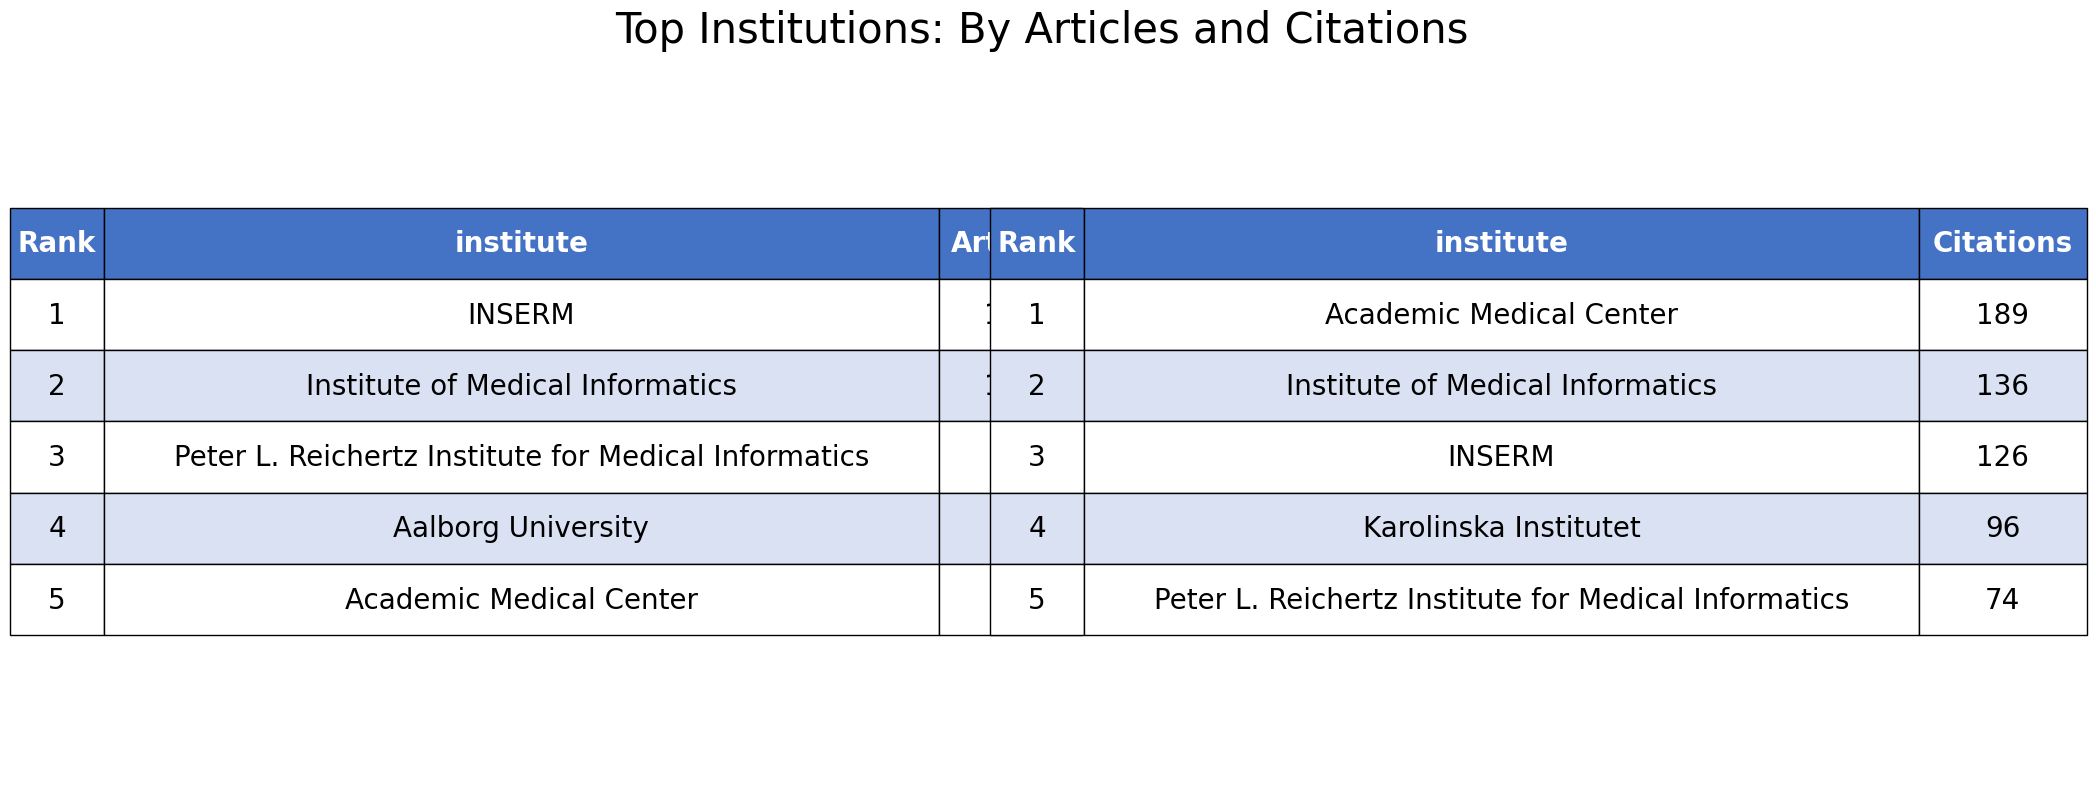

Tables drawn and saved successfully in `Institutions_comparison_tables.png`.


In [111]:
# Get the top Institutions (let's say top 10 for this example)
top = 5
top_n_by_citation_count = result.sort_values(by='citation_count', ascending=False).reset_index(drop=True).head(top)
top_n_by_article_count =  result.sort_values(by='article_count', ascending=False).reset_index(drop=True).head(top)

# Create two sorted dataframes
df_by_article = top_n_by_article_count[['institute', 'article_count']].sort_values('article_count', ascending=False)
df_by_article = df_by_article.rename(columns={'article_count': 'Articles'})
df_by_article['Rank'] = range(1, len(df_by_article) + 1)
df_by_article = df_by_article[['Rank'] + [col for col in df_by_article.columns if col != 'Rank']]

df_by_citation = top_n_by_citation_count[['institute', 'citation_count']].sort_values('citation_count', ascending=False)
df_by_citation = df_by_citation.rename(columns={'citation_count': 'Citations'})
df_by_citation['Rank'] = range(1, len(df_by_citation) + 1)
df_by_citation = df_by_citation[['Rank'] + [col for col in df_by_citation.columns if col != 'Rank']]


# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))  # Increased figure size
fig.suptitle("Top Institutions: By Articles and Citations", fontsize=30)  # Increased title font size

# Create tables
# table1 = create_table(ax1, top_n_by_article_count, "Sorted by Articles")
# table2 = create_table(ax2, df_by_citation, "Sorted by Citations")

table1 = create_table(ax1, df_by_article,"")
table2 = create_table(ax2, df_by_citation,"")
# Adjust layout and save the plot
plt.tight_layout()
if save_mode:
    plt.savefig(OUTPUT_DIR / "Institutions_comparison_tables.png", dpi=300, bbox_inches='tight')
plt.show()

print("Tables drawn and saved successfully in `Institutions_comparison_tables.png`.")

## University

In [112]:
uni_field = "universityf"
# Explode the structural_affiliations column
df_exploded = df.explode('structural_affiliations')

# Normalize the structural_affiliations column
df_normalized = pd.json_normalize(df_exploded['structural_affiliations'])

# Reset index and drop the original structural_affiliations column
df_exploded = df_exploded.reset_index(drop=True).drop('structural_affiliations', axis=1)

# Concatenate the exploded and normalized dataframes
df_final = pd.concat([df_exploded, df_normalized], axis=1)

# Function to handle both list and non-list values
def flatten_university(uni):
    if isinstance(uni, list):
        return uni[0] if uni else None
    return uni

# Apply the flatten_university function to the university column
df_final[uni_field] = df_final[uni_field].apply(flatten_university)

# Group by university and aggregate
result = df_final.groupby(uni_field).agg({
    'citation_count': 'sum',
    'title': 'nunique'  # Changed from 'count' to 'nunique' to avoid double counting
}).rename(columns={'title': 'article_count'}).reset_index()

# Sort the result by citation_count in descending order
result_sorted_by_citation_count = result.sort_values(by='citation_count', ascending=False).reset_index(drop=True)
if save_mode:
    result_sorted_by_citation_count.to_csv(OUTPUT_DIR / "table_university_citation_article_count.csv")
print("Tables created and saved successfully in `table_university_citation_article_count.csv`.")

Tables created and saved successfully in `table_university_citation_article_count.csv`.


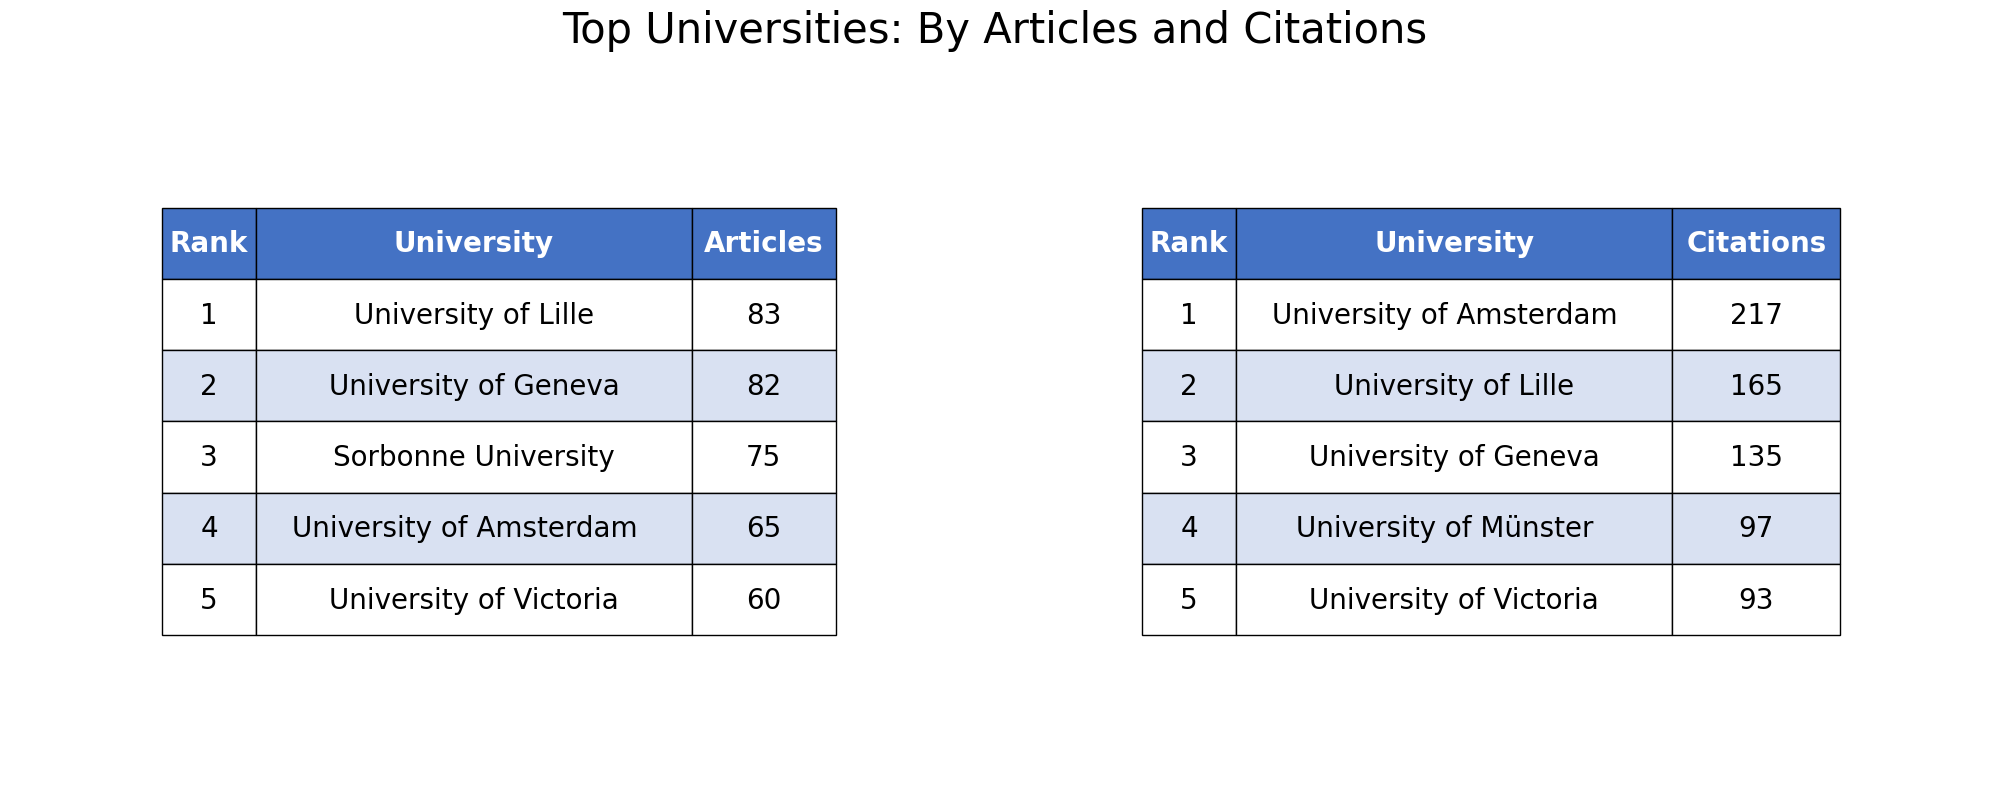

Tables drawn and saved successfully in `universities_comparison_tables.png`.


In [113]:
# Get the top universities (let's say top 10 for this example)
top = 6
top_n_by_citation_count = result.sort_values(by='citation_count', ascending=False).reset_index(drop=True).head(top)
top_n_by_article_count =  result.sort_values(by='article_count', ascending=False).reset_index(drop=True).head(top)

# Create two sorted dataframes
df_by_article = top_n_by_article_count[[uni_field, 'article_count']].sort_values('article_count',  ascending=False)
df_by_article = df_by_article.rename(columns={'article_count': 'Articles'})
df_by_article = df_by_article[df_by_article[uni_field] != 'No Uni']
df_by_article['Rank'] = range(1, len(df_by_article) + 1)
df_by_article = df_by_article[['Rank'] + [col for col in df_by_article.columns if col != 'Rank']]
df_by_article = df_by_article.rename(columns={uni_field: 'University'})

df_by_citation = top_n_by_citation_count[[uni_field, 'citation_count']].sort_values('citation_count', ascending=False)
df_by_citation = df_by_citation.rename(columns={'citation_count': 'Citations'})
df_by_citation = df_by_citation[df_by_citation[uni_field] != 'No Uni']
df_by_citation['Rank'] = range(1, len(df_by_citation) + 1)
df_by_citation = df_by_citation[['Rank'] + [col for col in df_by_citation.columns if col != 'Rank']]
df_by_citation = df_by_citation.rename(columns={uni_field: 'University'})

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))  # Increased figure size
fig.suptitle("Top Universities: By Articles and Citations", fontsize=30)  # Increased title font size


table1 = create_table(ax1, df_by_article,"")
table2 = create_table(ax2, df_by_citation,"")
# Adjust layout and save the plot
plt.tight_layout()
if save_mode:
    plt.savefig(OUTPUT_DIR / "universities_comparison_tables.png", dpi=300, bbox_inches='tight')
plt.show()

print("Tables drawn and saved successfully in `universities_comparison_tables.png`.")

## Understanding and Visualizing Co-occurrence Networks
In bibliometric analysis, co-occurrence networks are a powerful tool used to visualize and analyze the relationships between different entities, such as keywords, authors, or institutions, within a set of academic papers. These networks help identify patterns, trends, and collaborations within a research field. In this section, we will calculate and visualize co-occurrence networks for the MIE conference papers.

**Code Explanation**

1. **Initialization**: 
   - `c = CoOccurrenceCalculator()`: This line initializes an instance of the `CoOccurrenceCalculator` class. This class is designed to handle the computation of co-occurrence networks. It likely contains methods to process the data and generate the necessary network structures.

2. **Calculate Co-occurrence Networks**:
   - `c.calculate_all()`: This method is responsible for computing the co-occurrence networks. It processes the data from the MIE conference papers to identify and quantify the relationships between different entities. This step involves analyzing the frequency and patterns of co-occurrences, which are essential for constructing the network.

3. **Export Co-occurrence Networks**:
   - `c.plot_all_in_output()`: After calculating the networks, this method export them. The Exported files is crucial for interpreting the data, as it provides a graphical representation of the relationships and interactions within the dataset. The output is typically a series of graphs file that illustrate the co-occurrence patterns.

In [6]:
if save_mode:
    c = CoOccurrenceCalculator()
    c.calculate_all()
    c.plot_all_in_output()

Run calculate_all unlimited.


100%|██████████| 4606/4606 [00:01<00:00, 3890.98it/s]


keywords_co_occurring graph have 188 nodes.
topics_co_occurring graph have 1505 nodes.
countries_co_occurring graph have 91 nodes.
authors_co_occurring graph have 565 nodes.
universities_co_occurring graph have 191 nodes.


### Keyword Co-occurance Network
![](/output/vos_viewer_keyword_co_occurrence.png)